### Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.spatial import KDTree

### Data

In [35]:
mangaHIall = Table.read('input/mangaHIall_dnn.txt', format = 'ascii.commented_header')

## Separating walls and voids into separate tables

In [36]:
walls_data_boolean = np.isfinite(mangaHIall['HI-walls'])  
walls_data = mangaHIall[walls_data_boolean]

voids_data_boolean = np.isfinite(mangaHIall['HI-voids']) 
voids_data = mangaHIall[voids_data_boolean]

### Scatter plots


##### WF50 vs Distance to nearest neighbor plot

In [37]:
walls_WF50 = walls_data['WF50_corrected']
walls_dnn_WF50 = walls_data['d_nn']

voids_WF50 = voids_data['WF50_corrected']
voids_dnn_WF50 = voids_data['d_nn']

##### Mtot vs Distance to nearest neighbor plot

In [38]:
walls_data_Mtot_boolean = walls_data['Mtot'] > 0
walls_data_Mtot = walls_data[walls_data_Mtot_boolean]

walls_MTot = walls_data_Mtot['Mtot']
walls_dnn_MTot = walls_data_Mtot['d_nn']

###############################################

voids_data_Mtot_boolean = voids_data['Mtot'] > 0
voids_data_Mtot = voids_data[voids_data_Mtot_boolean]

voids_MTot = voids_data_Mtot['Mtot']
voids_dnn_MTot = voids_data_Mtot['d_nn']

##### Subplot

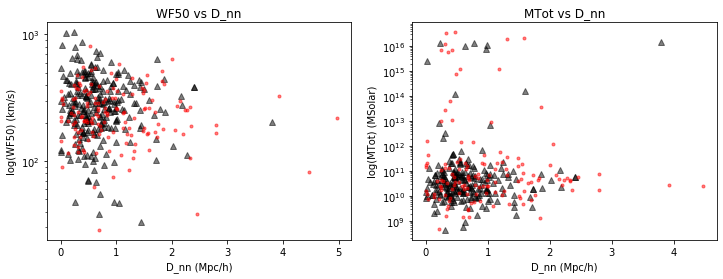

In [39]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].semilogy(walls_dnn_WF50, walls_WF50, '^', color = 'black', label = 'Walls', alpha = 0.5)
axs[0].semilogy(voids_dnn_WF50, voids_WF50, '.', color = 'red', label = 'Voids', alpha = 0.5)
axs[0].set_title('WF50 vs D_nn')
axs[0].set_ylabel('log(WF50) (km/s)')

axs[1].semilogy(walls_dnn_MTot, walls_MTot, '^', color = 'black', label = 'Walls', alpha = 0.5)
axs[1].semilogy(voids_dnn_MTot, voids_MTot, '.',color = 'red', label = 'Voids', alpha = 0.5)
axs[1].set_title('MTot vs D_nn')
axs[1].set_ylabel('log(MTot) (MSolar)')

for ax in axs.flat:
    ax.set(xlabel = 'D_nn (Mpc/h)')
    
plt.show()

##### WF50 vs Distance to nearest void center

In [40]:
walls_d_nvc_WF50 = walls_data['d_nvc']

voids_d_nvc_WF50 = voids_data['d_nvc']

In [41]:
walls_d_nvc_WF50_norm = walls_data['d_nvc_norm']

voids_d_nvc_WF50_norm = voids_data['d_nvc_norm']

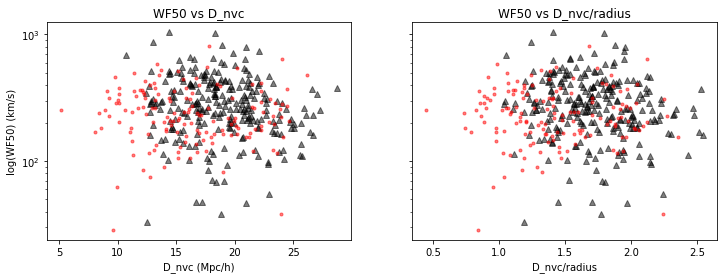

In [44]:
fig, axs = plt.subplots(1,2, sharey = True, figsize=(12,4))
axs[0].semilogy(walls_d_nvc_WF50, walls_WF50, '^', color = 'black', label = 'Walls', alpha = 0.5)
axs[0].semilogy(voids_d_nvc_WF50, voids_WF50, '.', color = 'red', label = 'Voids', alpha = 0.5)
axs[0].set_title('WF50 vs D_nvc')
axs[0].set_ylabel('log(WF50) (km/s)')
axs[0].set_xlabel('D_nvc (Mpc/h)')

axs[1].semilogy(walls_d_nvc_WF50_norm, walls_WF50, '^', color = 'black', label = 'Walls', alpha = 0.5)
axs[1].semilogy(voids_d_nvc_WF50_norm, voids_WF50, '.', color = 'red', label = 'Voids', alpha = 0.5)
axs[1].set_title('WF50 vs D_nvc/radius')
axs[1].set_xlabel('D_nvc/radius')

plt.show()

---

### Median plots

##### WF50 vs Distance to nearest neighbor 

In [204]:
def round_down(x):
    rounded_x = round(x)
    if rounded_x > x: # 9.6 -> 10, so ans is 9.5
        x = rounded_x - 0.5
    elif rounded_x < x: # 9.4 -> 9, so ans is 9
        x = rounded_x
    return x

def round_up(x):
    rounded_x = round(x)
    if rounded_x > x: # 9.6 -> 10, so ans is 10
        x = rounded_x 
    elif rounded_x < x: # 9.4 -> 9, so ans is 9.5
        x = rounded_x + 0.5
    return x

In [205]:
def bin_dist(data, lower, upper):
    """
    fn: bin_dist()
    description: Returns a binned data structure according to d_nn
    
    parameters:
        data: table of data, astropy table
        lower: min d_nn, float64
        upper: max d_nn, float64
        galaxyType: 'Voids'/'Walls', string
    
    return:
        bins: data structure containing binned data. bins is a list of lists. Each sublist corresponds
              to a bin.
    """
    bin_size = 0.5
   
    bins = []
    num_bins = int((upper - lower)/bin_size)
    for i in range(num_bins):
        bins.append([]) #generates empty sublists inside the list bins
    
    for i in range(len(data)):
            dist = data['d_nn'][i]
            bin_num = int((dist - lower)//bin_size) # which bin to put into
            bins[bin_num].append(dist) # adds to corresponding bin
     
    return bins
            

In [206]:
walls_lower_dist = round_down(min(walls_data['d_nn']))
walls_upper_dist = round_up(max(walls_data['d_nn']))

voids_lower_dist = round_down(min(voids_data['d_nn']))
voids_upper_dist = round_up(max(voids_data['d_nn']))

In [207]:
walls_dist_bins = bin_dist(walls_data, walls_lower_dist, walls_upper_dist)

voids_dist_bins = bin_dist(voids_data, voids_lower_dist, voids_upper_dist)

In [208]:
def bin_wf50(data, dist_bins):
    wf50_bins = []
    for _ in range(len(dist_bins)):
        wf50_bins.append([])
   
    #  loop through bins:
    #     find which row the mass is in
    #     add wf50 to corresponding bin from corresponding row
      
    for dist_bin in dist_bins:
        for dist in dist_bin:
            for i in range(len(data)):
                if dist == data['d_nn'][i]:
                    wf50_bins[dist_bins.index(dist_bin)].append(np.log10(data['WF50_corrected'][i]))
    
    return wf50_bins
            
        

In [209]:
walls_wf50_bins = bin_wf50(walls_data, walls_dist_bins)

voids_wf50_bins = bin_wf50(voids_data, voids_dist_bins)

In [210]:
def bin_midpoints(lower, upper):
    bin_size = 0.5
    bin_num = int((upper - lower)/bin_size)
    midpoints = []
    for i in range(bin_num):
        midpoints.append(lower + bin_size*(i + 0.5))
        # for every bin: midpoint = lower_bound_ofthatbin + bin_size/2
        # lower_bound_ofthatbin = lowest_bound + bin# * bin_size
        
    return midpoints

In [211]:
def bin_correction(l):
    while -999.0 in l:
        l.remove(-999.0)
    return l

In [212]:
walls_center_dist = bin_midpoints(walls_lower_dist, walls_upper_dist)
walls_center_dist_err = 0.25

walls_wf50_bins_medians = []
walls_wf50_bins_medians_err = []

for wf50_bin in walls_wf50_bins:
    if len(wf50_bin) < 2:
        walls_wf50_bins_medians.append(-999.0)
        walls_wf50_bins_medians_err.append(-999.0)
    else:
        walls_wf50_bins_medians.append(np.median(wf50_bin))
        walls_wf50_bins_medians_err.append(1/np.sqrt(len(wf50_bin)))

walls_wf50_bins_medians = bin_correction(walls_wf50_bins_medians)
walls_wf50_bins_medians_err = bin_correction(walls_wf50_bins_medians_err)
walls_center_dist = walls_center_dist[:5]

#############################################

voids_center_dist = bin_midpoints(voids_lower_dist, voids_upper_dist)
voids_center_dist_err = 0.25

voids_wf50_bins_medians = []
voids_wf50_bins_medians_err = []

for wf50_bin in voids_wf50_bins:
    if len(wf50_bin) < 2:
        voids_wf50_bins_medians.append(-999.0)
        voids_wf50_bins_medians_err.append(-999.0)
    else:
        voids_wf50_bins_medians.append(np.median(wf50_bin))
        voids_wf50_bins_medians_err.append(1/np.sqrt(len(wf50_bin)))

voids_wf50_bins_medians = bin_correction(voids_wf50_bins_medians)
voids_wf50_bins_medians_err = bin_correction(voids_wf50_bins_medians_err)
voids_center_dist = voids_center_dist[:6]

Mtot vs d_nn\
distance to void centers

##### Mtot vs Distance to nearest neighbor 

In [213]:
def bin_Mtot(data, dist_bins):
    Mtot_bins = []
    for _ in range(len(dist_bins)):
        Mtot_bins.append([])
   
    #  loop through bins:
    #     find which row the mass is in
    #     add Mtot to corresponding bin from corresponding row
      
    for dist_bin in dist_bins:
        for dist in dist_bin:
            for i in range(len(data)):
                if dist == data['d_nn'][i]:
                    Mtot_bins[dist_bins.index(dist_bin)].append(np.log10(data['Mtot'][i]))
    
    return Mtot_bins
            
        

In [214]:
walls_Mtot_bins = bin_Mtot(walls_data_Mtot, walls_dist_bins)

voids_Mtot_bins = bin_Mtot(voids_data_Mtot, voids_dist_bins)

In [215]:
walls_center_dist = bin_midpoints(walls_lower_dist, walls_upper_dist)
walls_center_dist_err = 0.25

walls_Mtot_bins_medians = []
walls_Mtot_bins_medians_err = []

for Mtot_bin in walls_Mtot_bins:
    if len(Mtot_bin) < 2:
        walls_Mtot_bins_medians.append(-999.0)
        walls_Mtot_bins_medians_err.append(-999.0)
    else:
        walls_Mtot_bins_medians.append(np.median(Mtot_bin))
        walls_Mtot_bins_medians_err.append(1/np.sqrt(len(Mtot_bin)))

walls_Mtot_bins_medians = bin_correction(walls_Mtot_bins_medians)
walls_Mtot_bins_medians_err = bin_correction(walls_Mtot_bins_medians_err)
walls_center_dist = walls_center_dist[:5]

#############################################

voids_center_dist = bin_midpoints(voids_lower_dist, voids_upper_dist)
voids_center_dist_err = 0.25

voids_Mtot_bins_medians = []
voids_Mtot_bins_medians_err = []

for Mtot_bin in voids_Mtot_bins:
    if len(Mtot_bin) < 2:
        voids_Mtot_bins_medians.append(-999.0)
        voids_Mtot_bins_medians_err.append(-999.0)
    else:
        voids_Mtot_bins_medians.append(np.median(Mtot_bin))
        voids_Mtot_bins_medians_err.append(1/np.sqrt(len(Mtot_bin)))

voids_Mtot_bins_medians = bin_correction(voids_Mtot_bins_medians)
voids_Mtot_bins_medians_err = bin_correction(voids_Mtot_bins_medians_err)
voids_center_dist = voids_center_dist[:6]

##### Subplot

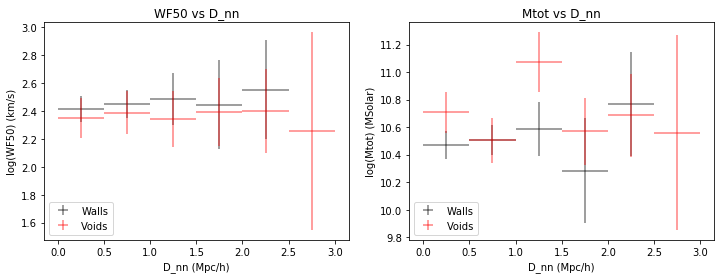

In [225]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].errorbar(walls_center_dist, walls_wf50_bins_medians, xerr = walls_center_dist_err , yerr= walls_wf50_bins_medians_err, fmt = 'none', color = 'black', label = 'Walls', alpha = 0.5)
axs[0].errorbar(voids_center_dist, voids_wf50_bins_medians, xerr = voids_center_dist_err , yerr= voids_wf50_bins_medians_err, fmt = 'none', color = 'red', label = 'Voids', alpha = 0.5)
axs[0].set_title('WF50 vs D_nn')
axs[0].set_ylabel('log(WF50) (km/s)')
axs[0].set_xlabel('D_nn (Mpc/h)')
axs[0].legend(loc = 'lower left')


axs[1].errorbar(walls_center_dist, walls_Mtot_bins_medians, xerr = walls_center_dist_err , yerr= walls_Mtot_bins_medians_err, fmt = 'none', color = 'black', label = 'Walls', alpha = 0.5)
axs[1].errorbar(voids_center_dist, voids_Mtot_bins_medians, xerr = voids_center_dist_err , yerr= voids_Mtot_bins_medians_err, fmt = 'none', color = 'red', label = 'Voids', alpha = 0.5)
axs[1].set_title('Mtot vs D_nn')
axs[1].set_ylabel('log(Mtot) (MSolar)')
axs[1].set_xlabel('D_nn (Mpc/h)')
axs[1].legend(loc = 'lower left')


plt.show()

##### WF50 vs Distance to nearest void center

In [226]:
def bin_dist_nvc(data, lower, upper):
    """
    fn: bin_dist()
    description: Returns a binned data structure according to d_nvc
    
    parameters:
        data: table of data, astropy table
        lower: min d_nn, float64
        upper: max d_nn, float64
    return:
        bins: data structure containing binned data. bins is a list of lists. Each sublist corresponds
              to a bin.
    """
    bin_size = 1
   
    bins = []
    num_bins = int((upper - lower)/bin_size)
    for i in range(num_bins):
        bins.append([]) #generates empty sublists inside the list bins
    
    for i in range(len(data)):
            dist = data['d_nvc'][i]
            bin_num = int((dist - lower)//bin_size) # which bin to put into
            bins[bin_num].append(dist) # adds to corresponding bin
     
    return bins
            

In [227]:
def bin_wf50_d_nvc(data, dist_bins):
    wf50_bins = []
    for _ in range(len(dist_bins)):
        wf50_bins.append([])
   
    #  loop through bins:
    #     find which row the mass is in
    #     add wf50 to corresponding bin from corresponding row
      
    for dist_bin in dist_bins:
        for dist in dist_bin:
            for i in range(len(data)):
                if dist == data['d_nvc'][i]:
                    wf50_bins[dist_bins.index(dist_bin)].append(np.log10(data['WF50_corrected'][i]))
    
    return wf50_bins
            
        

In [228]:
walls_lower_dist_vc = round_down(min(walls_data['d_nvc']))
walls_upper_dist_vc = round_up(max(walls_data['d_nvc']))

voids_lower_dist_vc = round_down(min(voids_data['d_nvc']))
voids_upper_dist_vc = round_up(max(voids_data['d_nvc']))

In [229]:
voids_lower_dist_vc

5.0

In [230]:
walls_dist_vc_bins = bin_dist_nvc(walls_data, walls_lower_dist_vc, walls_upper_dist_vc)

voids_dist_vc_bins = bin_dist_nvc(voids_data, voids_lower_dist_vc, voids_upper_dist_vc)

IndexError: list index out of range

In [193]:
len(walls_dist_vc_bins)

74

In [194]:
walls_wf50_vc_bins = bin_wf50_d_nvc(walls_data, walls_dist_vc_bins)

voids_wf50_vc_bins = bin_wf50_d_nvc(voids_data, voids_dist_vc_bins)

In [195]:
walls_center_dist_vc = bin_midpoints(walls_lower_dist_vc, walls_upper_dist_vc)
walls_center_dist_vc_err = 0.5

walls_wf50_vc_bins_medians = []
walls_wf50_vc_bins_medians_err = []

for wf50_bin in walls_wf50_vc_bins:
    if len(wf50_bin) < 2:
        walls_wf50_vc_bins_medians.append(-999.0)
        walls_wf50_vc_bins_medians_err.append(-999.0)
    else:
        walls_wf50_vc_bins_medians.append(np.median(wf50_bin))
        walls_wf50_vc_bins_medians_err.append(1/np.sqrt(len(wf50_bin)))

walls_wf50_vc_bins_medians = bin_correction(walls_wf50_vc_bins_medians)
walls_wf50_vc_bins_medians_err = bin_correction(walls_wf50_vc_bins_medians_err)
walls_center_dist_vc = walls_center_dist_vc[:30]

#############################################

voids_center_dist_vc = bin_midpoints(voids_lower_dist_vc, voids_upper_dist_vc)
voids_center_dist_vc_err = 0.5

voids_wf50_vc_bins_medians = []
voids_wf50_vc_bins_medians_err = []

for wf50_bin in voids_wf50_vc_bins:
    if len(wf50_bin) < 2:
        voids_wf50_vc_bins_medians.append(-999.0)
        voids_wf50_vc_bins_medians_err.append(-999.0)
    else:
        voids_wf50_vc_bins_medians.append(np.median(wf50_bin))
        voids_wf50_vc_bins_medians_err.append(1/np.sqrt(len(wf50_bin)))

voids_wf50_vc_bins_medians = bin_correction(voids_wf50_vc_bins_medians)
voids_wf50_vc_bins_medians_err = bin_correction(voids_wf50_vc_bins_medians_err)
voids_center_dist_vc = voids_center_dist_vc[:30]


AssertionError: 

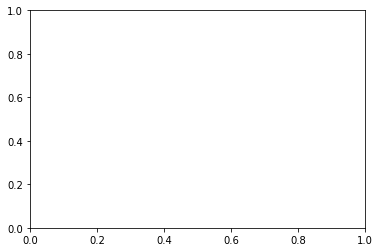

In [196]:
plt.errorbar(voids_center_dist_vc, voids_wf50_vc_bins_medians, xerr = voids_center_dist_vc_err, yerr = voids_wf50_vc_bins_medians_err, fmt ='none', color = 'red', alpha = 0.5, label = 'Voids')
plt.errorbar(walls_center_dist_vc, walls_wf50_vc_bins_medians, xerr = walls_center_dist_vc_err, yerr = walls_wf50_vc_bins_medians_err, fmt ='none', color = 'black', alpha = 0.5, label = 'Walls')
plt.ylabel('log(WF50) (km/s)')
plt.xlabel('D_nvc (Mpc/h)')
plt.legend()
plt.show()